Created on Nov 20, 2023

Learning based on https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

In [1]:
# importing the libraries
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
# loading the data
test_df = pd.read_csv("Titanic/test.csv")
train_df = pd.read_csv("Titanic/train.csv")

In [38]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We observe that there are some columns having null as information

In [41]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


1. Convert a lot of features into numeric
2. Convert the feature range to the same scale
3. Deal with missing values

In [42]:
total = train_df.isnull().sum().sort_values(ascending=False) # numbers of missing values
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1,1)).sort_values(ascending=False) # round the percentages and rank by descending order
missing_data = pd.concat([total, percent_2],axis=1, keys=['Total','%']) # concate the two columns together with axis = 1
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


We might drop the Cabin feature since it is largely missing.

In [43]:
train_df.columns.values # the names of the columns

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Text(0.5, 1.0, 'Male')

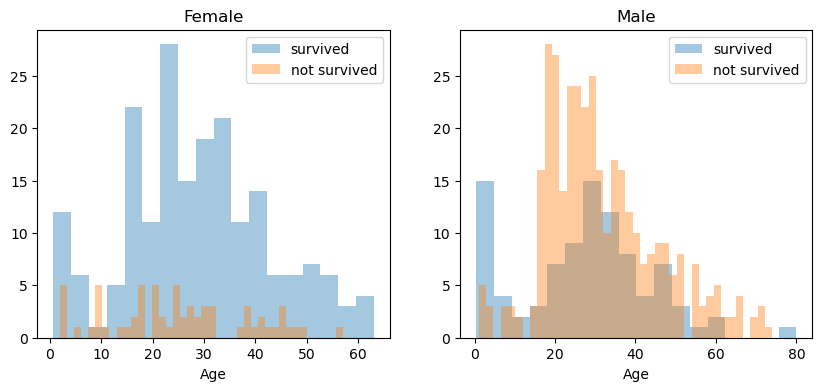

In [44]:
# information on age and sex
survived = 'survived' # label
not_survived = 'not survived' # label

fix,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

women = train_df[train_df['Sex']=='female'] # df for women passengers
men = train_df[train_df['Sex']=='male'] # df for men passengers

ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label=survived, ax=axes[0],kde=False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label=not_survived, ax=axes[0],kde=False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label=survived, ax=axes[1],kde=False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label=not_survived, ax=axes[1],kde=False)
ax.legend()
ax.set_title('Male')

There are certain ages, which have increased odds of survival.

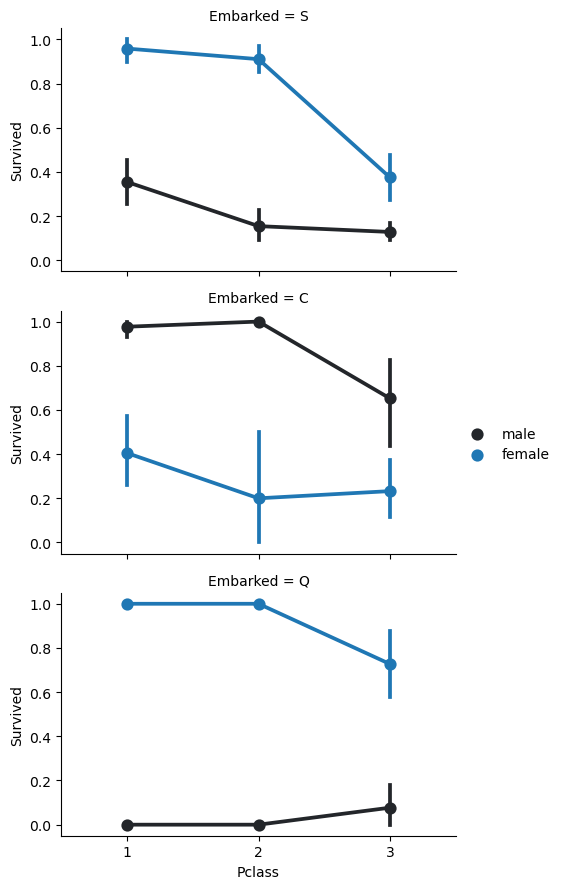

In [45]:
# information on embarked Pclass and sex
FacetGrid = sns.FacetGrid(train_df, row='Embarked', aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass','Survived','Sex')
FacetGrid.add_legend()

survival rate is correlated with the class and the embarkement place

<Axes: xlabel='Pclass', ylabel='Survived'>

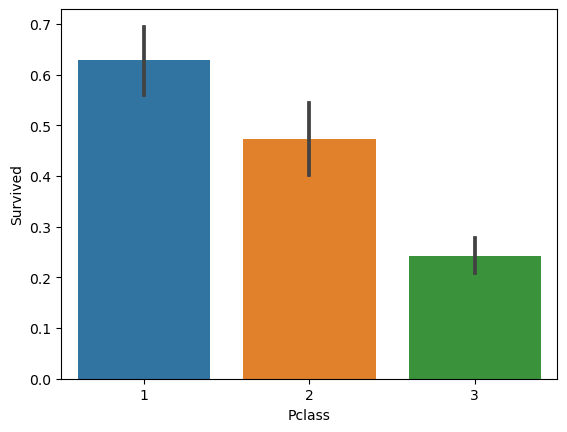

In [46]:
# Pclass
sns.barplot(x='Pclass',y='Survived',data=train_df)

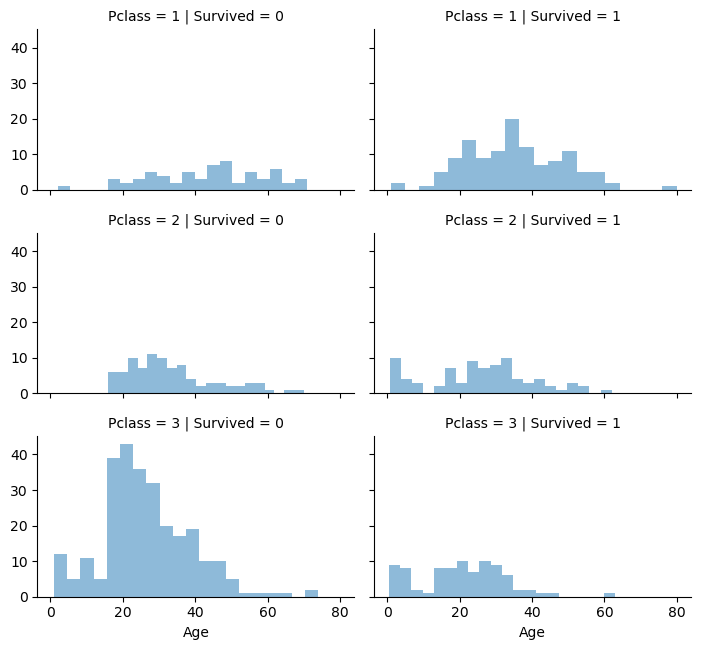

In [47]:
grid = sns.FacetGrid(train_df, col='Survived',row='Pclass',height=2.2,aspect=1.6)
grid.map(plt.hist, 'Age',alpha=0.5, bins=20)
grid.add_legend()

In [60]:
# sibsp and parch
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

not_alone
1    537
0    354
Name: count, dtype: int64

# Data processing

In [48]:
train_df = train_df.drop(['PassengerId'],axis=1) # it doesn't contribute to the survival rate 
# not drop from the test set since it's demanded for submission

## Missing data

Cabin is serverely missing, but the letter in the Cabin refers to the deck of this person. So we can create a new feature refering to the person's deck.

In [49]:
import re

In [50]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna('U0')
    dataset['Deck'] = dataset['Cabin'].map(lambda x:re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
train_df = train_df.drop(['Cabin'],axis=1)
test_df = test_df.drop(['Cabin'],axis=1)

In [51]:
# fill the missing agese with random age
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum() # number of null values
    # give random age
    rand_age = np.random.randint(mean-std, mean+std, size=is_null)
    # fill the nan values
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

In [52]:
# fill the embarked information with the common value
train_df["Embarked"].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [53]:
common_value='S'
data = [train_df, test_df]

for dataset in data:
    dataset["Embarked"] = dataset["Embarked"].fillna(common_value)

## converting features

In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int32  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    int32  
dtypes: float64(1), int32(2), int64(4), object(4)
memory usage: 69.7+ KB


In [55]:
# convert fare into integer
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [57]:
# get the titles of the passenger
data = [train_df, test_df]
titles = {"Mr":1, "Miss":2, "Mrs":3, "Master":4,"Rare":5}

for dataset in data:
    # get titles
    dataset["Title"] = dataset.Name.str.extract('([A-Za-z]+)\.',expand=False)
    # replace rare titles
    dataset["Title"] = dataset["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    # convert into numerical representation
    dataset["Title"] = dataset["Title"].map(titles)
    
    dataset["Title"] = dataset["Title"].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [58]:
# map sex into numeric results
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [59]:
# drop the tickets feature, there are too many unique tickets
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [62]:
train_df["Embarked"].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [63]:
# convert embarked into numeric
ports = {"S":0, "C":1, "Q":2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(genders)

## Creating groups

In [64]:
data = [train_df, test_df]
# age grouping
for dataset in data:
    dataset["Age"] = dataset["Age"].astype(int) # convert into integers
    dataset.loc[dataset["Age"]<=11, "Age"] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [66]:
pd.qcut(dataset["Fare"],6)

0      (-0.001, 7.0]
1      (-0.001, 7.0]
2        (8.0, 14.0]
3         (7.0, 8.0]
4        (8.0, 14.0]
           ...      
413       (7.0, 8.0]
414    (55.5, 512.0]
415    (-0.001, 7.0]
416       (7.0, 8.0]
417     (14.0, 26.0]
Name: Fare, Length: 418, dtype: category
Categories (6, interval[float64, right]): [(-0.001, 7.0] < (7.0, 8.0] < (8.0, 14.0] < (14.0, 26.0] < (26.0, 55.5] < (55.5, 512.0]]

In [67]:
data = [train_df, test_df]
# fare grouping
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
train_df["Fare"].value_counts()

Fare
0    241
2    223
1    216
3    158
4     44
5      9
Name: count, dtype: int64

## Creating new features

In [68]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [69]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,relatives,not_alone,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,NaN,8,1,1,0,6,0
1,1,1,1,5,1,0,3,NaN,3,3,1,0,5,1
2,1,3,1,3,0,0,0,NaN,8,2,0,1,9,0
3,1,1,1,5,1,0,3,NaN,3,3,1,0,5,1
4,0,3,0,5,0,0,1,NaN,8,1,0,1,15,1
5,0,3,0,4,0,0,1,NaN,8,1,0,1,12,1
6,0,1,0,6,0,0,3,NaN,5,1,0,1,6,3
7,0,3,0,0,3,1,2,NaN,8,4,4,0,0,0
8,1,3,1,3,0,2,1,NaN,8,3,2,0,9,0
9,1,2,1,1,1,0,2,NaN,8,3,1,0,2,1


# Building Machine Learning Models

Test set doesn't have labels. Therefore we will use the predictions on the training set to compare the results of different algorithms. 